# Basic use of Clapeyron

In [1]:
using Clapeyron
import PyPlot; const plt = PyPlot

PyPlot

## Model construction - Ideal Gas
All calculations in Clapeyron revolve around an object we typically call the `model`. These models are meant to carry all of the information required to use a given thermodynamic model. The simplest of these is the basic, monoatomic ideal gas model (`BasicIdeal`), which requires no parameters:

In [2]:
model = BasicIdeal();

We can now use this object to obtain any property of interest (that is applicable to the ideal gas):

In [3]:
p = 1e5
T = 298.15
z = [1.]
V = volume(model, p, T, z)

0.02478957029602388

Where `p` is the pressure in Pa, `T` is the temperature in Kelvin, and `z` is the mole amount of each species (a vector). Within Clapeyron, we treat (almost) all bulk calculations using an $NpT$ ensemble. Pretty much all bulk properties will be written as `property(model, p, T, z)`:

In [4]:
S  = entropy(model, p, T, z) # 61.1035079831524 J/K
μ  = chemical_potential(model, p, T, z) # -12020.618331170917 J/mol
Cp = isobaric_heat_capacity(model, p, T, z) # 20.786156545383097 J/K
βT = isothermal_compressibility(model, p, T, z); # 1e-5 1/Pa

The `BasicIdeal` model contains no species-specific information. For real species, even at an ideal gas level, they will contain specific contributions arising from rotational and vibrational modes of motion. To account for this, a few ideal gas models have been developed. One of these is the `ReidIdeal` model:

In [5]:
model = ReidIdeal(["carbon dioxide"])

ReidIdeal with 1 component:
 "carbon dioxide"
Contains parameters: a, b, c, d, e, coeffs, reference_state, Mw

One can look at the parameters under `model.params`:

In [6]:
model.params

Clapeyron.ReidIdealParam for ["carbon dioxide"] with 8 params:
 a::SingleParam{Float64}
 b::SingleParam{Float64}
 c::SingleParam{Float64}
 d::SingleParam{Float64}
 e::SingleParam{Float64}
 coeffs::SingleParam{NTuple{5, Float64}}
 reference_state::ReferenceState
 Mw::SingleParam{Float64}

In [7]:
model.params.a

SingleParam{Float64}("a") with 1 component:
 "carbon dioxide" => 27.096833672561402

Everything else still works exactly the same where you will see that only the thermal properties have changed:

In [8]:
V = volume(model, p, T, z) # 0.02478957029602388 m^3
S  = entropy(model, p, T, z) # -39.0413486790645 J/K
μ  = chemical_potential(model, p, T, z) # 11645.730929258245 J/mol
Cp = isobaric_heat_capacity(model, p, T, z) # 37.021984876735104 J/K
βT = isothermal_compressibility(model, p, T, z); # 1e-5 1/Pa

Clapeyron has large pre-existing databases which contain parameters for many species across multiple models. Even then, we don't have parameters for all species. In the case where no parameters are available, it is possible to provide user-defined parameters in one of two ways. The fastest way is within the code itself:

In [9]:
model = ReidIdeal(["wangium"]; userlocations=(;
    Mw = [18.01528],
    a = [10.],
    b = [5e-3],
    c = [7e-5],
    d = [2e-8],
    e = [1e-11]
))

ReidIdeal with 1 component:
 "wangium"
Contains parameters: a, b, c, d, e, coeffs, reference_state, Mw

The other method would be through `.csv` files which is discussed more in the [docs](https://clapeyronthermo.github.io/Clapeyron.jl/stable/tutorials/user_defined_parameters). While defining parameters inline is convenient, some more-complicated models require many more parameters and, to keep things organized, it is better to store them in `.csv` files.

## Model Construction - Helmholtz-based models
Ideal gas models are by far the simplest class of models available in Clapeyron. To model the behavior of real fluids, we provide two classes of models. The first of these we refer to as Helmholtz-based models. These are any equation of state which can be expressed in terms of a residual Helmholtz free energy:

$$
A_\mathrm{res} = f(V,T,\mathbf{z})
$$

This includes cubics, SAFT-type and empirical models. The residual contribution is meant to account for all other types of interactions (van der Waals, polar, hydrogen bonding, electrostatics, conformational entropy etc.). 

When it comes to constructing them, everything works pretty much the same as the ideal gas models. If the parameters are available, one can simply:

In [10]:
model = PR(["water"])

PR{BasicIdeal, PRAlpha, NoTranslation, vdW1fRule} with 1 component:
 "water"
Contains parameters: a, b, Tc, Pc, Mw

### Bulk properties

Bulk properties are obtained exactly the same way:

In [11]:
V = volume(model, p, T, z)

2.1390790444209544e-5

There is one small caveat: below the critical point, pure species can exist either in the gas or liquid phase. By default, Clapeyron will obtain both and return the phase which minimizes the Gibbs free energy. This is best observed over a wide temperature range:

In [12]:
p = 1e5
T = LinRange(280.,550,100)
V = volume.(model, p, T); # if no composition is specified, Clapeyron assumes z = [1.0]

Note that the `.` operator is used to broadcast the function call over the array of temperatures `T`, allowing for efficient computation of the volume at each temperature.

However, if one wanted to obtain just the liquid or just the vapor roots, all that would need to be done is to specify the `phase` kwarg:

In [13]:
Vv = volume.(model,p,T;phase=:vapour)
Vl = volume.(model,p,T;phase=:liquid);

Visualizing the results:

In [14]:
plt.clf()

plt.semilogy(T,Vv.*1e6,linestyle="--",color="blue",label="Vapour")
plt.semilogy(T,Vl.*1e6,linestyle=":",color="blue",label="Liquid")
plt.semilogy(T,V.*1e6,linestyle="-",color="blue",label="Stable")

plt.xlabel("Temperature / K",fontsize=16)
plt.ylabel("Volume / (cm³/mol)",fontsize=16)
plt.ylim(1e1,5e5)
plt.xlim([280,550])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="upper left",frameon=false,fontsize=11)

PyObject <matplotlib.legend.Legend object at 0x321879990>

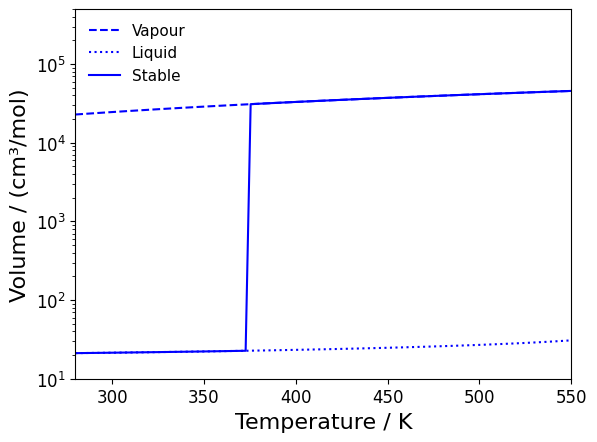

In [15]:
display(plt.gcf())

We can see that the phase transition occurs almost exactly at $T=373.15\,\mathrm{K}$. All other bulk properties will pretty much work the same way.

### Vapor–liquid equilibrium properties

Another set of properties one might be interested in would be the condition at which the vapor and liquid phases co-exist (the saturation point). Let us say we would like to know the vapor pressure of water at $T=298.15\,\mathrm{K}$. To do so, one must solve a simultaneous set of non-linear equations:

$$
p(V_l,T) = p(V_v,T)
$$
$$
\mu(V_l,T) = \mu(V_v,T)
$$

With two equations and two unknowns, this problem should be solvable. Indeed, this is what is done internally with Clapeyron when one uses the `saturation_pressure(model, T)` function:

In [16]:
T = 298.15
(p, vl, vv) = saturation_pressure(model, T)

(2686.595773329244, 2.1391045835208427e-5, 0.922332512018773)

An equivalent function exists for the saturation temperature:

In [17]:
p = 1e5
(T, vl, vv) = saturation_temperature(model, p)

(374.2402124727243, 2.2697623673985157e-5, 0.030849393761972824)

If desired, one can use these functions to trace out the full VLE envelope of water. One crucial piece of information that will be needed: the critical point. Thankfully, there is an function that obtains it for us:

In [18]:
(Tc, pc, vc) = crit_pure(model)

(647.13, 2.19e7, 7.552440558745412e-5)

Note that, for cubics, the critical point is a parameter. In other models such as SAFT-based ones, the critical point must be solved numerically. 

With this, we can now trace the full phase diagram:

In [ ]:
N    = 100

T    = LinRange(298.15, Tc,  N)
psat = zeros(N)
vl   = zeros(N)
vv   = zeros(N)

for i in 1:N
    sat = saturation_pressure(model, T[i])
    psat[i] = sat[1]
    vl[i] = sat[2]
    vv[i] = sat[3]
end

Plotting the $pT$ curve:

In [20]:
plt.clf()
plt.semilogy(T, psat./1e6, color="blue")
plt.plot([Tc],[pc]./1e6, marker="o",color="blue")
plt.xlabel("Temperature / K",fontsize=16)
plt.ylabel("Pressure / MPa",fontsize=16)
plt.xlim([300,690])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

([0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], PyCall.PyObject[PyObject Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'), PyObject Text(0, 0.001, '$\\mathdefault{10^{-3}}$'), PyObject Text(0, 0.01, '$\\mathdefault{10^{-2}}$'), PyObject Text(0, 0.1, '$\\mathdefault{10^{-1}}$'), PyObject Text(0, 1.0, '$\\mathdefault{10^{0}}$'), PyObject Text(0, 10.0, '$\\mathdefault{10^{1}}$'), PyObject Text(0, 100.0, '$\\mathdefault{10^{2}}$'), PyObject Text(0, 1000.0, '$\\mathdefault{10^{3}}$')])

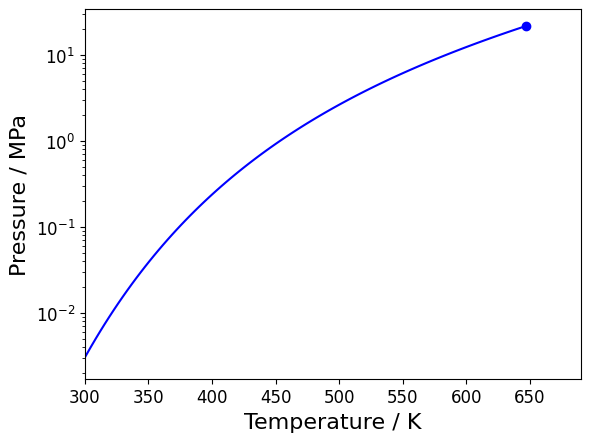

In [21]:
display(plt.gcf())

And the $\rho T$ curve:

In [22]:
plt.clf()
plt.plot(1e-3 ./vl, T, color="blue")
plt.plot(1e-3 ./vv, T, color="blue")

plt.plot([1e-3/vc],[Tc], marker="o",color="blue")
plt.ylabel("Temperature / K",fontsize=16)
plt.xlabel("Density / (mol/dm³)",fontsize=16)
plt.ylim([300,690])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

([300.0, 350.0, 400.0, 450.0, 500.0, 550.0, 600.0, 650.0, 700.0], PyCall.PyObject[PyObject Text(0, 300.0, '300'), PyObject Text(0, 350.0, '350'), PyObject Text(0, 400.0, '400'), PyObject Text(0, 450.0, '450'), PyObject Text(0, 500.0, '500'), PyObject Text(0, 550.0, '550'), PyObject Text(0, 600.0, '600'), PyObject Text(0, 650.0, '650'), PyObject Text(0, 700.0, '700')])

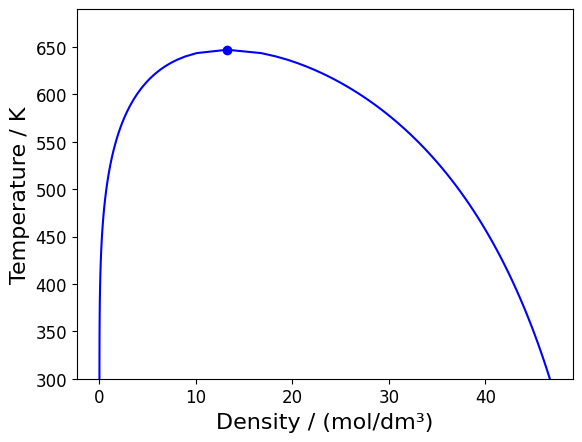

In [23]:
display(plt.gcf())

For most cases, this covers what one might be interested in for pure components.

## Binary mixtures
Building a model for a binary (or multicomponent) mixture isn't that much more challenging:

In [24]:
model = PCSAFT(["cyclohexane", "methanol"])

PCSAFT{BasicIdeal, Float64} with 2 components:
 "cyclohexane"
 "methanol"
Contains parameters: Mw, segment, sigma, epsilon, epsilon_assoc, bondvol

### Bulk properties

What does become more challenging is the properties one may want to obtain. Generally, bulk properties can be obtained as:

In [25]:
p = 1e5
T = 298.15
z = [0.5,0.5]
V = volume(model, p, T, z)

7.63206620394643e-5

Note that these calculations assume the mixture exists as a single phase (more on that later). 

In most cases, when it comes to binary mixtures, we are usually more interested in excess properties rather than total:
$$
X_E = X_\mathrm{mix} - \sum_i x_i X_i^* -\Delta X_\mathrm{id-mix}
$$
where, for most properties, $\Delta X_\mathrm{id-mix}=0$. These can be obtained using the `excess` function:


In [26]:
x = range(0,1,length=100)
X = Clapeyron.FractionVector.(x) # FractionVector is used to make it easier to broadcast across compositions
V_E = excess.(model,p,T,X,volume);

Plotting:

In [27]:
plt.clf()
plt.plot(1 .-x,V_E.*1e6,label="PR",linestyle="-",color="blue")
plt.xlabel("composition of cyclohexane",fontsize=16)
plt.ylabel("Excess Volume / (cm³/mol)",fontsize=16)
plt.ylim([0.,1.])
plt.xlim([0,1])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig("excess_vol_etoh_h2o.svg")

([0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0], PyCall.PyObject[PyObject Text(0, 0.0, '0.0'), PyObject Text(0, 0.2, '0.2'), PyObject Text(0, 0.4, '0.4'), PyObject Text(0, 0.6000000000000001, '0.6'), PyObject Text(0, 0.8, '0.8'), PyObject Text(0, 1.0, '1.0')])

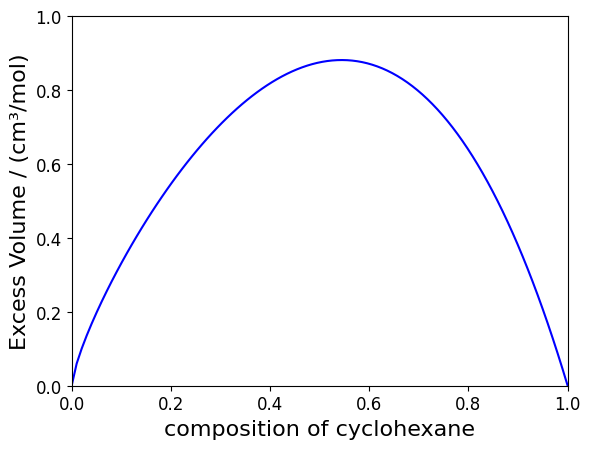

In [28]:
display(plt.gcf())

This can also be done for any other bulk property!

### Vapor–Liquid Equilibrium
Examining vapor-liquid equilibrium of binary mixtures now becomes a lot more challenging. The conditions can now be written as:
$$
p(V_l,T,\mathbf{x}_l) = p(V_v,T,\mathbf{y}_v)
$$
$$
\mu_1(V_l,T,\mathbf{x}_l) = \mu_1(V_v,T,\mathbf{y}_v)
$$
$$
\mu_2(V_l,T,\mathbf{x}_l) = \mu_2(V_v,T,\mathbf{y}_v)
$$
where we now have three equations and four unknowns (assuming compositions add up to one), meaning we must specify one of the unknowns. Let us say we want to obtain the bubble point of this mixture at a given temperature and liquid composition ($\mathbf{x}_l$ is now specified). We can obtain this by using the `bubble_pressure(model, T, x)` function:

In [29]:
T = 298.15
x = [0.5,0.5]
(p, vl, vv, y) = bubble_pressure(model, T, x)

(27926.78138837041, 7.632937356775668e-5, 0.08498568298922671, [0.4488562229605732, 0.5511437770394267])

An equivalent function exists for the dew pressure, as well as for bubble and dew temperatures.

Drawing out the full phase diagram is now a bit tricky as we have three variables which define the phase space (composition, temperature and pressure). A convenient way to visualize the phase equilibrium is to take a 2D slice where one of the three variables have been fixed. In this tutorial, we will take an isobaric slice. A similar methodology can be used to obtain an isothermal slice. Constant composition slices are more challenging; guidance can be found in another [notebook](https://github.com/ClapeyronThermo/Clapeyron.jl/blob/master/examples/binary_phase_equilibrium.ipynb).

In [30]:
N    = 201
p    = 1e5

x    = LinRange(0., 1.,  N)
T    = zeros(N)
y    = zeros(N)

v0 = nothing
for i in 1:N
    bub = bubble_temperature(model, p, [x[i], 1-x[i]])
    T[i] = bub[1]
    y[i] = bub[4][1]
end

Plotting:

In [33]:
plt.clf()
plt.plot(x, T, color="red")
plt.plot(y, T, color="red")
plt.xlabel("composition / (mol/mol)",fontsize=16)
plt.ylabel("Temperature / K",fontsize=16)
plt.xlim([0,1])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

([325.0, 330.0, 335.0, 340.0, 345.0, 350.0, 355.0], PyCall.PyObject[PyObject Text(0, 325.0, '325'), PyObject Text(0, 330.0, '330'), PyObject Text(0, 335.0, '335'), PyObject Text(0, 340.0, '340'), PyObject Text(0, 345.0, '345'), PyObject Text(0, 350.0, '350'), PyObject Text(0, 355.0, '355')])

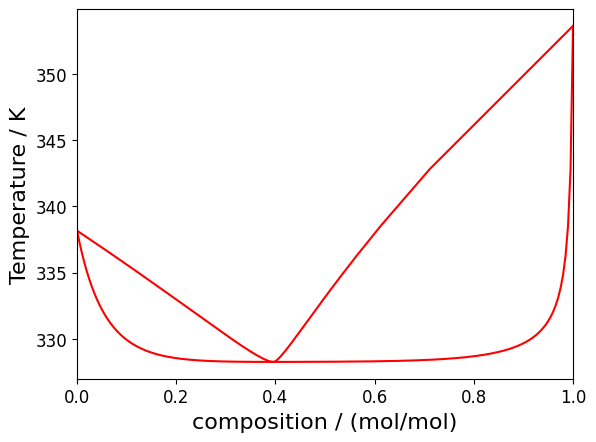

In [34]:
display(plt.gcf())

This code should generalize to most subcritical binary mixtures.

### Liquid–Liquid Equilibrium
Our choice of a methanol+cyclohexane mixture was intentional as, not only does it exhibit vapor–liquid equilibrium, it also exhibits liquid–liquid equilibrium. This is most evident when we consider the Gibbs free energy of mixing:

In [38]:
p = 1e5
T_lle = 288.15
x_lle = range(0,1,length=100)
X = Clapeyron.FractionVector.(x_lle) # FractionVector is used to make it easier to broadcast across compositions
g_mix = mixing.(model,p,T_lle,X,gibbs_free_energy);

Plotting:

In [39]:
plt.clf()
plt.plot(1 .-x_lle,g_mix,label="PR",linestyle="-",color="blue")
plt.xlabel("composition of cyclohexane",fontsize=16)
plt.ylabel("Excess Gibbs Free Energy / (J/mol)",fontsize=16)
# plt.ylim([-200,0.])
plt.xlim([0,1])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig("excess_vol_etoh_h2o.svg")

([-200.0, -175.0, -150.0, -125.0, -100.0, -75.0, -50.0, -25.0, 0.0, 25.0], PyCall.PyObject[PyObject Text(0, -200.0, '−200'), PyObject Text(0, -175.0, '−175'), PyObject Text(0, -150.0, '−150'), PyObject Text(0, -125.0, '−125'), PyObject Text(0, -100.0, '−100'), PyObject Text(0, -75.0, '−75'), PyObject Text(0, -50.0, '−50'), PyObject Text(0, -25.0, '−25'), PyObject Text(0, 0.0, '0'), PyObject Text(0, 25.0, '25')])

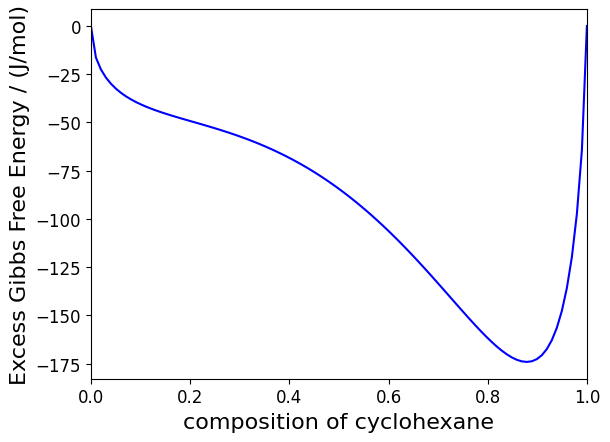

In [40]:
display(plt.gcf())

We can see that there should be two coexisting phases present.

In this case, what we would like to do is figure out: what is the state of the system at a given $\mathbf{z}_0$, $p$ and $T$? This is also typically referred to as a flash calculation. In Clapeyron, this is done with the `tp_flash(model, p, T, z)` method. This can easily work for vapor–liquid equilibrium:

In [199]:
p = 1e5
T_vle = 340.
z = [0.8, 0.2]
(X,n,G) = tp_flash(model, p, T_vle, z, RRTPFlash(equilibrium=:vle))
X

2×2 Matrix{Float64}:
 0.992125  0.00787493
 0.645266  0.354734

Where the compositions of each component in each phase is stored within `X`.

Clapeyron has internal functions to handle the initial guesses for $\mathbf{K}^{\mathrm{VLE}}$. For LLE, one needs to use a slightly more-advanced flash algorithm called `MichelsenTPFlash`. In general, for LLE, it is generally safe to assumed that equimolar compositions should be somewhere in the middle of the phase diagram:

In [204]:
p = 1e5
T_lle = 298.15
z = [0.5, 0.5]
(X,n,G) = tp_flash(model, p, T_lle, z, MichelsenTPFlash(equilibrium=:lle))
X

2×2 Matrix{Float64}:
 0.201414  0.798586
 0.88242   0.11758

With this, we can now trace the LLE region. We can't really find out ahead of time what the exact position of the UCST is. As such, the only way to end the trace is to stop the calculation when the two compositions approach similar values:

In [200]:
N    = 200
Tlle = LinRange(300.,minimum(T),N)
x1   = zeros(N)
x2   = zeros(N)

K0 = [1e5, 1e-4]
z  = [0.5,0.5]

idxend = N
for i in 1:N
    (n,_,_) = tp_flash(model, p, Tlle[i], z, MichelsenTPFlash(equilibrium=:lle, K0=K0))
    K0 = n[2,:]./n[1,:]
    z = (n[1,:]+n[2,:])/2
    x1[i] = n[1,1]
    x2[i] = n[2,1]
    if abs(x1[i]-x2[i])<1e-3
        idxend = i
        break
    end
end

Combining the VLE and LLE regions:

In [202]:
plt.clf()
plt.plot(x, T, color="red")
plt.plot(y, T, color="red")

plt.plot(x1[1:idxend], Tlle[1:idxend], color="red")
plt.plot(x2[1:idxend], Tlle[1:idxend], color="red")
plt.xlabel("composition / (mol/mol)",fontsize=16)
plt.ylabel("Temperature / K",fontsize=16)
plt.xlim([0,1])
plt.ylim([300,355])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig("meoh_cyhex_Txy_lle.png")

([300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0], PyCall.PyObject[PyObject Text(0, 300.0, '300'), PyObject Text(0, 310.0, '310'), PyObject Text(0, 320.0, '320'), PyObject Text(0, 330.0, '330'), PyObject Text(0, 340.0, '340'), PyObject Text(0, 350.0, '350'), PyObject Text(0, 360.0, '360')])

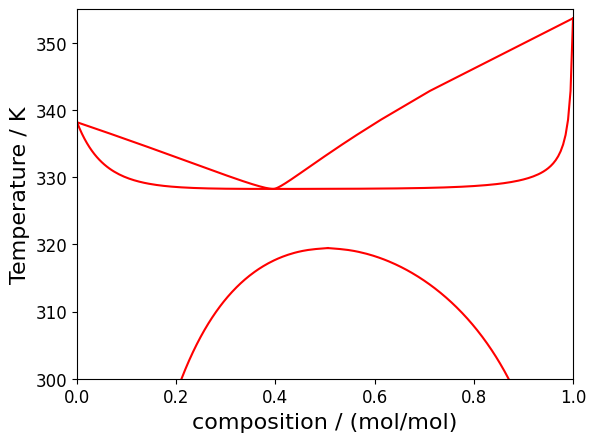

In [203]:
display(plt.gcf())

This type of phase diagram is quite simple. Binary phase diagrams can become very complicated. See the full [notebook](https://github.com/ClapeyronThermo/Clapeyron.jl/blob/master/examples/binary_phase_equilibrium.ipynb) for more examples.

### Solid–liquid equilibrium
All models considered thus far only consider fluid phases (vapor and liquid). The solid phase must be handled by a separate model. This can be done using the `CompositeModel` framework, which allows users to combine multiple models in the hopes of accessing phenomena the models couldn't handle in isolation. This is particularly useful when one would like to model solid–liquid equilibrium through the following equation:
$$
\ln a_i = -\frac{\Delta h_{\mathrm{fus},i}}{k_\mathrm{B}}\left(\frac{1}{T}-\frac{1}{T_{\mathrm{fus},i}}\right)
$$
Let us model the solid–liquid equilibrium between 1-decanol and thymol:

In [4]:
model = CompositeModel(["1-decanol","thymol"]; fluid=PCSAFT, solid=SolidHfus)

Composite Model with 2 components:
 "1-decanol"
 "thymol"
Solid Model: SolidHfus("1-decanol", "thymol")
Fluid Model: PCSAFT{BasicIdeal, Float64}("1-decanol", "thymol")

We can solve for the composition of the liquid phase in equilibrium with a pure solid phase (specified by the `solute` argument):

In [5]:
p  = 1e5
T  = 277.15
z0 = [0.5,0.5] # Initial ratio; no effect in a binary mixture
s  = sle_solubility(model, p, T, z0; solute=["1-decanol"])

2-element Vector{Float64}:
 0.8567444678533104
 0.14325553214668965

To draw the full solid–liquid equilibrium phase diagram, it is a bit easier to solve for the equilibrium temperature rather than equilibrium composition, using `sle_solubility_T(model, x, p)`:

In [6]:
x = [0.8,0.2]
p = 1e5
T = Clapeyron.sle_solubility_T(model, x, p)

277.774546589946

Tracing the full diagram:

In [7]:
x = LinRange(0.,1.0, 200)
T = zeros(length(x))
T[1] = model.solid.params.Tm[2]
T[end] = model.solid.params.Tm[1]

for i in 2:length(x)-1
    T[i] = Clapeyron.sle_solubility_T(model, [x[i], 1-x[i]], p)
end

Plotting:

In [8]:
plt.clf()
plt.plot(x, T, color="blue")
T_E = minimum(T)
x_E = x[argmin(T)]
plt.plot([0, 1], [T_E, T_E], color="blue", linestyle="--")
plt.plot([x_E],[T_E], marker="s",color="blue")
plt.xlabel("composition / (mol/mol)",fontsize=16)
plt.ylabel("Temperature / K",fontsize=16)
plt.xlim([0,1])
plt.ylim([275,325])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

([270.0, 280.0, 290.0, 300.0, 310.0, 320.0, 330.0], PyCall.PyObject[PyObject Text(0, 270.0, '270'), PyObject Text(0, 280.0, '280'), PyObject Text(0, 290.0, '290'), PyObject Text(0, 300.0, '300'), PyObject Text(0, 310.0, '310'), PyObject Text(0, 320.0, '320'), PyObject Text(0, 330.0, '330')])

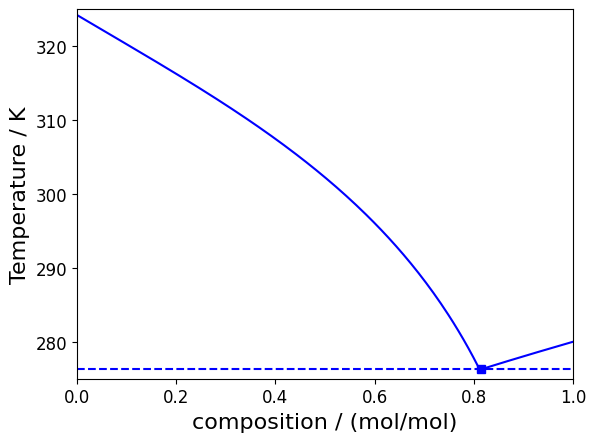

In [9]:
display(plt.gcf())